## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we will introduce the Grad-CAM which visualizes the heatmap of input images by highlighting the important region for visual question answering(VQA) task.

* **To be submitted**: this notebook in two weeks, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


# <font color='red'> Important: I used Google Colab to run this jupyter notebook. In the end, I wanted to use the function cv2.imshow but it was not supported by Colab, and it advised me to use cv2_imshow with "from google.colab.patches import cv2_imshow" instead. If you run it on your pc without Colab, I doubt it will work so you should remove this line from the first cell and try to use cv2.imshow instead of cv2_imshow when it is used in the end</font>




In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

import torchvision.transforms as transforms
from PIL import Image

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visual Question Answering problem
Given an image and a question in natural language, the model choose the most likely answer from 3 000 classes according to the content of image. The VQA task is indeed a multi-classificaition problem.
<img src="vqa_model.PNG">

We provide you a pretrained model `vqa_resnet` for VQA tasks.

In [2]:
# load model
from load_model import load_model
vqa_resnet = load_model()

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth


In [3]:
print(vqa_resnet) # for more information 

VQA_Resnet_Model(
  (text): TextProcessor(
    (embedding): Embedding(15193, 300, padding_idx=0)
    (drop): Dropout(p=0.5, inplace=False)
    (tanh): Tanh()
    (lstm): LSTM(300, 1024)
  )
  (attention): Attention(
    (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (q_lin): Linear(in_features=1024, out_features=512, bias=True)
    (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    (drop): Dropout(p=0.5, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (classifier): Classifier(
    (drop1): Dropout(p=0.5, inplace=False)
    (lin1): Linear(in_features=5120, out_features=1024, bias=True)
    (relu): ReLU()
    (drop2): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=1024, out_features=3000, bias=True)
  )
  (resnet_layer4): ResNetLayer4(
    (r_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [4]:
checkpoint = '2017-08-04_00.55.19.pth'
saved_state = torch.load(checkpoint, map_location=device)
# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w

### Inputs
In order to use the pretrained model, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(448, 448)`. You can call the function `image_to_features` to achieve image preprocessing. For input question, the function `encode_question` is provided to encode the question into a vector of indices. You can also use `preprocess` function for both image and question preprocessing.

In [5]:
def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Scale(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [6]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

In [7]:
# preprocess requires the dir_path of an image and the associated question. 
#It returns the spectific input form which can be used directly by vqa model. 
def preprocess(dir_path, question):
    q, q_len = encode_question(question)
    img = Image.open(dir_path).convert('RGB')
    image_size = 448  # scale image to given size and center
    central_fraction = 1.0
    transform = get_transform(image_size, central_fraction=central_fraction)
    img_transformed = transform(img)
    img_features = img_transformed.unsqueeze(0).to(device)
    
    inputs = (img_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return inputs

We provide you two pictures and some question-answers.

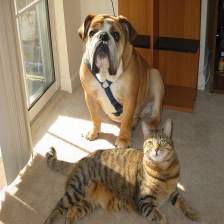

In [8]:
Question1 = 'What animal'
Answer1 = ['dog','cat' ]
indices1 = [answer_to_index[ans] for ans in Answer1]# The indices of category 
img1 = Image.open('dog_cat.png')
img1

In [9]:
dir_path = 'dog_cat.png' 
inputs = preprocess(dir_path, Question1)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.numpy())
print(answer_words[answer_idx])

dog


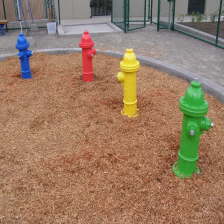

In [10]:
Question2 = 'What color'
Answer2 = ['green','yellow' ]
indices2 = [answer_to_index[ans] for ans in Answer2]
img2 = Image.open('hydrant.png')
img2

In [11]:
dir_path = 'hydrant.png' 
inputs = preprocess(dir_path, Question2)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.numpy())
print(answer_words[answer_idx])

green


### Grad-CAM 
* **Overview:** Given an image with a question, and a category (‘dog’) as input, we foward propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (dog), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the two images. For each image, consider the answers we provided as the desired classes. Compare the heatmaps of different answers, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model `vqa_resnet` doesn't have the activation function after its last layer, the output is indeed the `raw class scores`, you can use it directly. Run "print(vqa_resnet)" to get more information on VGG model.
 + The last CNN layer of the model is: `vqa_resnet.resnet_layer4.r_model.layer4[2].conv3` 
 + The size of feature maps is 14x14, so as your heatmap. You need to project the heatmap to the original image(224x224) to have a better observation. The function `cv2.resize()` may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

<img src="grad_cam.png">

In [12]:
# Definition of the global variables

output_cnn = None
grad_output_cnn = None


def visu_Grad_CAM(path_to_image, question, label):

    # Save output and grad_output of the last CNN layer

    def printnorm(self, input, output):
        global output_cnn
        output_cnn = output

    def printgradnorm(self, grad_input, grad_output):
        global grad_output_cnn
        grad_output_cnn = grad_output[0]

    vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_forward_hook(printnorm)
    vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_backward_hook(printgradnorm)


    vqa_resnet.zero_grad()

    inputs = preprocess(path_to_image, question)
    ans = torch.squeeze(vqa_resnet(*inputs))
    ans = ans[answer_to_index[label]]
    ans.backward()

    # We compute the Grad_CAM

    alpha = torch.sum(grad_output_cnn, dim=(0, 2, 3)) / (grad_output_cnn.size()[2] * grad_output_cnn.size()[3])

    Grad_CAM = F.relu(sum([alpha[k] * output_cnn[0][k] for k in range(output_cnn.size()[1])]))

    # Computation of the heatmap

    heatmap = Grad_CAM.detach().numpy()
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = heatmap - np.amin(heatmap)
    heatmap = heatmap / np.amax(heatmap)
    heatmap = np.uint8(heatmap * 255)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # We display the results

    image = cv2.imread(path_to_image, 1)
    image_with_heatmap = cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)

    print('Original image')
    cv2_imshow(image)
    print('Heatmap')
    cv2_imshow(heatmap)
    print('Original image with heatmap')
    cv2_imshow(image_with_heatmap)


Original image


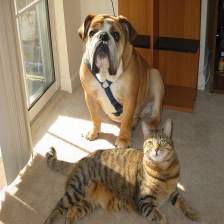

Heatmap


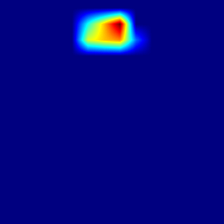

Original image with heatmap


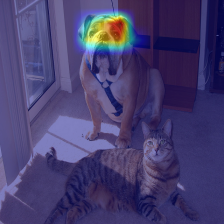

In [13]:
path_to_image = 'dog_cat.png'
question = 'What animal'
label = 'dog'

visu_Grad_CAM(path_to_image, question, label)

Original image


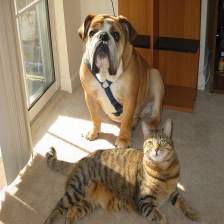

Heatmap


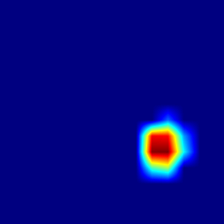

Original image with heatmap


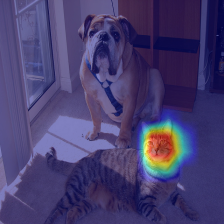

In [14]:
path_to_image = 'dog_cat.png'
question = 'What animal'
label = 'cat'

visu_Grad_CAM(path_to_image, question, label)

Original image


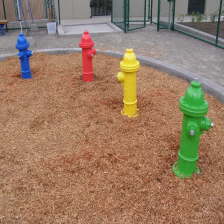

Heatmap


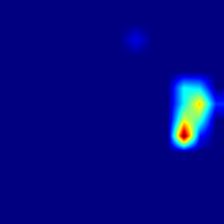

Original image with heatmap


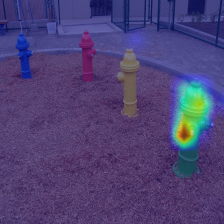

In [15]:
path_to_image = 'hydrant.png'
question = 'What color'
label = 'green'

visu_Grad_CAM(path_to_image, question, label)

In [ ]:
path_to_image = 'hydrant.png'
question = 'What color'
label = 'yellow'

visu_Grad_CAM(path_to_image, question, label)

# <font color='red'> Important: I used Google Colab to run this jupyter notebook. In the end, I wanted to use the function cv2.imshow but it was not supported by Colab, and it advised me to use cv2_imshow with "from google.colab.patches import cv2_imshow" instead. If you run it on your pc without Colab, I doubt it will work so you should remove this line from the first cell and try to use cv2.imshow instead of cv2_imshow when it is used in the end</font>




<font color='red'> I coded the Grad_CAM method for visualizing what the neural network looks at when it takes an image and a question as input and tries to find out if it matches a certain label.</font>

<font color='red'>I used the functions given in the hints for the calculation of the output and the gradient with respect to the output of the last CNN layer.</font>

<font color='red'>I normalized the heatmap and transformed it into an image, which I combined with the original image.</font>

<font color='red'>You can see that for the first image, the heatmap contains high values only where there is information, i.e. on the dog's head for the label 'dog' and on the cat's head for the label 'cat'.</font>

<font color='red'>For the second image, with the label 'green', we get a heatmap such that the high values are only on the green post. For the 'yellow' label, the highest values are on the yellow post but there are also values on the green post, so the result is less clear.</font>

<font color='red'>On the examples shown, the method works well. However, for the second image, when we replace the label by 'red' for example, it does not work anymore.</font>
